<a id='classical_Ising_QAOA_example'></a>
**Toy example of QAOA**

A simple example of QAOA for the 1D classical Ising model.
We consider the case of three spins (N = 3) with local magnetic fields (h<sub>i</sub>)

The Hamiltonian has the form <br>
$$ H = -z_1 z_2 - z_2 z_3 + h_1 + h_2 + h_3 $$

Adapted from https://pennylane.ai/qml/demos/tutorial_qaoa_intro/

----------

By Damian Pope, PhD

<i>Introduction to Quantum  Machine Learning</i> lecture




In [1]:
!pip install pennylane

Defaulting to user installation because normal site-packages is not writeable


In [2]:
"""
PennyLane code for a simple example of QAOA
https://pennylane.ai/
"""

import pennylane as qml
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt

h_1 = 1
h_2 = -1
h_3 = 1

#
#Create Hamiltonian for the quantum Ising model.
#It's based on the classical Hamiltonian: H = - z_1 z_2
#
H_Ising = qml.Hamiltonian(
    [-1,-1,-h_1,-h_2,-h_3],
    [qml.PauliZ(0) @ qml.PauliZ(1),qml.PauliZ(1) @ qml.PauliZ(2),qml.PauliZ(0), qml.PauliZ(1),qml.PauliZ(2)]
)
print(f"H_Ising={H_Ising}")

#Create the "simple" Hamilonian (H_s) that we start in the ground state of
H_s = qml.Hamiltonian(
    [1,1,1],
    [qml.PauliX(0), qml.PauliX(1),qml.PauliX(2)])

print(f"H_s={H_s}")

H_Ising=-1 * (Z(0) @ Z(1)) + -1 * (Z(1) @ Z(2)) + -1 * Z(0) + 1 * Z(1) + -1 * Z(2)
H_s=1 * X(0) + 1 * X(1) + 1 * X(2)


Implement QAOA with H_Ising and H_s

In [3]:
#Define the basic combination of implementing H_Ising and H_s that we will repeat a number of times (M times)
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, H_Ising)
    qaoa.mixer_layer(alpha, H_s)


#wires is the set of all the qubits.
#It's just [0,1] for qubit 0 and qubit 1.
wires = range(3)

#M is the number of times we repeat the combination (or layer) of H_s & H_Ising
P = 3

#define the circuit that implements QAOA
def circuit(params, **kwargs):

    #First, initialize the state to the ground state of H_s
    for w in wires:
        qml.PauliX(wires=w)
        qml.Hadamard(wires=w)

    #Implement H_s and H_Ising M times
    qml.layer(qaoa_layer, P, params[0], params[1])

Create the classical optimization procedure using gradient descent.

In [4]:
dev = qml.device("default.qubit", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(H_Ising)

optimizer = qml.GradientDescentOptimizer()
steps = 10

params = np.array([[0.5,0.5,0.5], [0.5,0.5,0.5]], requires_grad=True)

Run the QAOA algorithm and determine the optimal parameters.

In [5]:
for i in range(steps):
    params = optimizer.step(cost_function, params)

print(f"Optimal Parameters={params}")

Optimal Parameters=[[0.37693888 0.66553694 0.65460785]
 [0.49831115 0.51244042 0.44308106]]


Simulate running the algorithms a number of times and sampling the probability distribution of outcomes for the final optimzed values of the 2M time parameters.

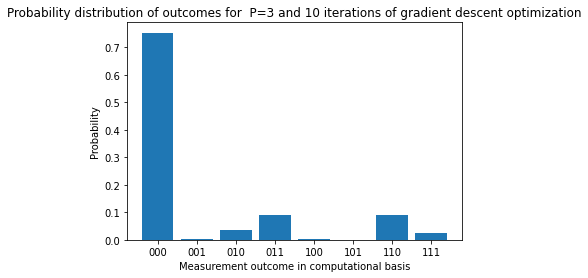

In [6]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

probs = probability_circuit(params[0], params[1])

#Display a bar graph showing the probability of measuring each bitstring
plt.bar(['000','001','010','011','100','101','110','111'], probs)
plt.title(f"Probability distribution of outcomes for  P={P} and {steps} iterations of gradient descent optimization")
plt.ylabel("Probability")
plt.xlabel("Measurement outcome in computational basis")
plt.show()